# **Análisis de Depresión mediante Redes Neuronales**

En este proyecto  desarrollamos modelos de Machine Learning capaz de predecir la presencia de síntomas depresivos en estudiantes universitarios mediante el análisis de indicadores relacionados con su estilo de vida, hábitos académicos y salud mental. Para ello, se utiliza un conjunto de datos de 27,901 participantes, cada uno descrito mediante 9 atributos clave que incluyen edad, promedio académico (CGPA), duración del sueño, nivel de estudios, carga horaria, antecedentes familiares de enfermedades mentales y presencia de pensamientos suicidas. La variable objetivo Depression es binaria (1 = síntomas presentes, 0 = sin síntomas), constituyendo una herramienta potencial para la detección temprana de riesgos en el ámbito académico.

Durante el desarrollo del trabajo, pusimos en práctica varios de los conceptos vistos en clase, como la configuración de modelos, la selección de parámetros adecuados y la evaluación del rendimiento. Más allá de obtener métricas favorables, el proceso nos permitió entender cómo pequeños cambios en la configuración pueden influir significativamente en los resultados. Además, trabajar con un caso tan cercano como la salud mental estudiantil nos ayudó a conectar la teoría con una problemática real, dándole mayor sentido a lo aprendido y reforzando nuestro interés por esta área.

##### INTEGRANTES:
  1. Jheison Estiben Gomez Muñoz -  2310215
  2. Cristian Daniel Medina Ortiz - 2310117


### Preparación de los Datos

Paso 1: Comenzamos con la carga y preprocesamiento de los datos, paso fundamental antes del entrenamiento de los modelos.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# División y validación
from sklearn.model_selection import train_test_split, learning_curve

# Modelo
from sklearn.neural_network import MLPClassifier

# Evaluación
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Configuración de advertencias
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Configuración de estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Carga del conjunto de datos
df = pd.read_csv("depression.csv")


Paso 2: Seleccionar aleatoriamente el 80% del conjunto de datos para entrenar y el 20% restante para las pruebas

In [2]:
# Dividimos datos en características (X) y objetivo (y)
X = df.drop('Depression', axis=1)
y = df['Depression']

# Dividimos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=123,
    stratify=y  
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")
print(f"Proporción de clases en entrenamiento: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Proporción de clases en prueba: {y_test.value_counts(normalize=True).to_dict()}")

Tamaño del conjunto de entrenamiento: 22320 muestras
Tamaño del conjunto de prueba: 5581 muestras
Proporción de clases en entrenamiento: {1: 0.5854838709677419, 0: 0.41451612903225804}
Proporción de clases en prueba: {1: 0.5855581437018456, 0: 0.41444185629815444}


Paso 3: Utilizar una estrategia para normalizar los datos numéricos y una forma de codificar los atributos categóricos

In [3]:
# Identificamos columnas numéricas y categóricas
numeric_cols = ['Age', 'CGPA', 'Work/Study Hours']
categorical_cols = ['Gender', 'Sleep Duration', 'Degree', 'Suicidal Thoughts', 'Family History of Mental Illness']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Aplicamos transformaciones
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Obtenemos nombres de características después de one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
new_cat_cols = cat_encoder.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, new_cat_cols])

print(f"Forma de los datos de entrenamiento transformados: {X_train_prep.shape}")
print(f"Número de características después del preprocesamiento: {X_train_prep.shape[1]}")

Forma de los datos de entrenamiento transformados: (22320, 14)
Número de características después del preprocesamiento: 14


Paso 4: Construir 5 redes neuronales variando en la topología de la red la cantidad de capas ocultas y de neuronas por cada capa oculta. Puede también variar los hiperparámetros solver y la función de activación. En todas las pruebas debe usar un random_state=123.


In [4]:
# Definimos las configuraciones de las redes
configurations = [
    # Config 1: 1 capa oculta (50 neuronas)
    {
        'name': "1 Capa (50)",
        'hidden_layer_sizes': (50,),
        'solver': 'adam',
        'activation': 'relu'
    },
    # Config 2: 2 capas ocultas (100, 50)
    {
        'name': "2 Capas (100,50)",
        'hidden_layer_sizes': (100, 50),
        'solver': 'sgd',
        'activation': 'tanh'
    },
    # Config 3: 3 capas ocultas (150, 100, 50)
    {
        'name': "3 Capas (150,100,50)",
        'hidden_layer_sizes': (150, 100, 50),
        'solver': 'adam',
        'activation': 'logistic'
    },
    # Config 4: 1 capa ancha (200 neuronas)
    {
        'name': "1 Capa Ancha (200)",
        'hidden_layer_sizes': (200,),
        'solver': 'lbfgs',
        'activation': 'relu'
    },
    # Config 5: 2 capas estrechas (80, 30)
    {
        'name': "2 Capas (80,30)",
        'hidden_layer_sizes': (80, 30),
        'solver': 'adam',
        'activation': 'tanh'
    }
]

# Entrenamos y evaluamos los modelos definidos anteriormente
results = []
models = []

for config in configurations:
    print(f"\nEntrenando modelo: {config['name']}")
    print(f"- Arquitectura: {config['hidden_layer_sizes']}")
    print(f"- Solver: {config['solver']}, Activación: {config['activation']}")

    # Creamos los pipeline con StandardScaler y MLPClassifier
    pipeline = make_pipeline(
        StandardScaler(),
        MLPClassifier(
            hidden_layer_sizes=config['hidden_layer_sizes'],
            solver=config['solver'],
            activation=config['activation'],
            random_state=123,
            max_iter=1000,
            early_stopping=True,
            n_iter_no_change=50
        )
    )

    # Entrenamos el pipeline
    pipeline.fit(X_train_prep, y_train)

    # Evaluamos el modelo
    y_pred = pipeline.predict(X_test_prep)
    acc = accuracy_score(y_test, y_pred)

    # Accedemos al modelo interno
    mlp_model = pipeline.named_steps['mlpclassifier']

    # Almacenamos los resultados
    results.append({
        'Modelo': config['name'],
        'Capas Ocultas': str(config['hidden_layer_sizes']),
        'Solver': config['solver'],
        'Activación': config['activation'],
        'Accuracy': acc,
        'Épocas': mlp_model.n_iter_
    })

    models.append(pipeline)
    print(f"Accuracy: {acc:.4f}, Épocas entrenadas: {mlp_model.n_iter_}")

# Convertimos los resultados a DataFrame
results_df = pd.DataFrame(results)
print("\nResumen de resultados:")
display(results_df)


Entrenando modelo: 1 Capa (50)
- Arquitectura: (50,)
- Solver: adam, Activación: relu
Accuracy: 0.7848, Épocas entrenadas: 135

Entrenando modelo: 2 Capas (100,50)
- Arquitectura: (100, 50)
- Solver: sgd, Activación: tanh
Accuracy: 0.7844, Épocas entrenadas: 55

Entrenando modelo: 3 Capas (150,100,50)
- Arquitectura: (150, 100, 50)
- Solver: adam, Activación: logistic
Accuracy: 0.7852, Épocas entrenadas: 75

Entrenando modelo: 1 Capa Ancha (200)
- Arquitectura: (200,)
- Solver: lbfgs, Activación: relu
Accuracy: 0.7506, Épocas entrenadas: 1000

Entrenando modelo: 2 Capas (80,30)
- Arquitectura: (80, 30)
- Solver: adam, Activación: tanh
Accuracy: 0.7844, Épocas entrenadas: 128

Resumen de resultados:


,Modelo,Capas Ocultas,Solver,Activación,Accuracy,Épocas
0,1 Capa (50),"(50,)",adam,relu,0.784806,135
1,"2 Capas (100,50)","(100, 50)",sgd,tanh,0.784447,55
2,"3 Capas (150,100,50)","(150, 100, 50)",adam,logistic,0.785164,75
3,1 Capa Ancha (200),"(200,)",lbfgs,relu,0.750582,1000
4,"2 Capas (80,30)","(80, 30)",adam,tanh,0.784447,128


Paso 5: Incluya en el notebook una tabla con el accuracy obtenido sobre el conjunto de prueba para las 5 redes neuronales del punto anterior



Resultados comparativos de las 5 configuraciones:


,Modelo,Capas Ocultas,Solver,Activación,Accuracy
0,1 Capa (50),"(50,)",adam,relu,0.784806
1,"2 Capas (100,50)","(100, 50)",sgd,tanh,0.784447
2,"3 Capas (150,100,50)","(150, 100, 50)",adam,logistic,0.785164
3,1 Capa Ancha (200),"(200,)",lbfgs,relu,0.750582
4,"2 Capas (80,30)","(80, 30)",adam,tanh,0.784447


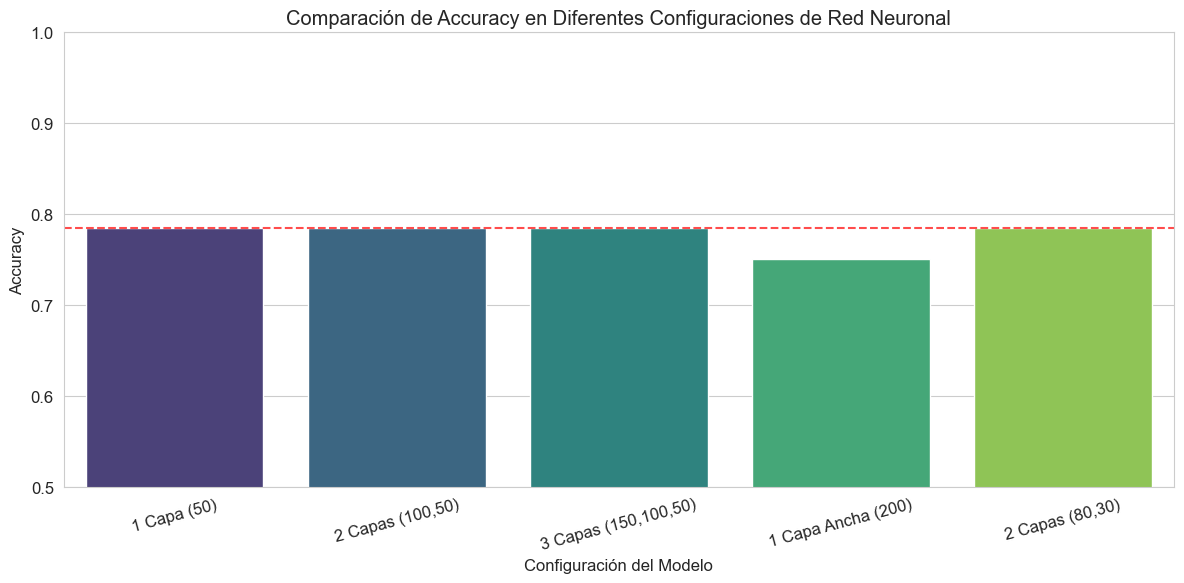

In [5]:
# Creamos una tabla de resultados
print("\nResultados comparativos de las 5 configuraciones:")
display(results_df[['Modelo', 'Capas Ocultas', 'Solver', 'Activación', 'Accuracy']])

# Visualizamos la comparación de accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='Modelo', y='Accuracy', hue='Modelo', data=results_df, palette='viridis', legend=False)
plt.axhline(results_df['Accuracy'].max(), color='red', linestyle='--', alpha=0.7)
plt.title('Comparación de Accuracy en Diferentes Configuraciones de Red Neuronal')
plt.ylabel('Accuracy')
plt.xlabel('Configuración del Modelo')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Paso 6: Indique en el notebook, usando una celda de tipo texto, los hiperparámetros que por el momento le permiten obtener la red con mayor accuracy


In [6]:
# buscamos la mejor configuración 
best_idx = results_df['Accuracy'].idxmax()
best_config = results_df.loc[best_idx]

print("\nMejor configuración encontrada:")
print(f"- Modelo: {best_config['Modelo']}")
print(f"- Accuracy: {best_config['Accuracy']:.4f}")
print(f"- Capas: {best_config['Capas Ocultas']}")
print(f"- Solver: {best_config['Solver']}")
print(f"- Función de activación: {best_config['Activación']}")



Mejor configuración encontrada:
- Modelo: 3 Capas (150,100,50)
- Accuracy: 0.7852
- Capas: (150, 100, 50)
- Solver: adam
- Función de activación: logistic


Paso 7: Seleccione uno de los hiperparámetros disponibles en la documentación (https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) que sea diferente al solver, a la función de activación, y al random_state. Realice dos variaciones en el hiperparámetro seleccionado manteniendo los otros hiperparámetros del punto anterior. Indique el accuracy obtenido al modificar el hiperparámetro seleccionado y analice si la red mejora, empeora, o mantiene su exactitud. Incluya en el notebook dicho análisis


In [7]:
# Usamos el mejor modelo como base
best_model = models[best_idx]
best_mlp = best_model.named_steps['mlpclassifier']  
print(f"\nExperimentando con el hiperparámetro alpha en el modelo: {best_config['Modelo']}")

# Probaremos diferentes valores de alpha
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1.0]
alpha_results = []

for alpha in alpha_values:
    print(f"\nEntrenando con alpha = {alpha}")

    mlp = MLPClassifier(
        hidden_layer_sizes=best_mlp.hidden_layer_sizes,
        solver=best_mlp.solver,
        activation=best_mlp.activation,
        alpha=alpha,
        random_state=123,
        max_iter=1000,
        early_stopping=True,
        n_iter_no_change=50
    )
    mlp.fit(X_train_prep, y_train)

    y_pred = mlp.predict(X_test_prep)
    acc = accuracy_score(y_test, y_pred)

    alpha_results.append({
        'alpha': alpha,
        'Accuracy': acc,
        'Épocas': mlp.n_iter_,
        'Cambio': 'Mejora' if acc > best_config['Accuracy'] else
                  'Empeora' if acc < best_config['Accuracy'] else 'Mantiene'
    })

    print(f"Accuracy: {acc:.4f}, Épocas: {mlp.n_iter_}")

# Convertimos los resultados a DataFrame
alpha_df = pd.DataFrame(alpha_results)
print("\nResultados variando alpha:")
display(alpha_df)

best_alpha_row = alpha_df.loc[alpha_df['Accuracy'].idxmax()]




Experimentando con el hiperparámetro alpha en el modelo: 3 Capas (150,100,50)

Entrenando con alpha = 0.0001
Accuracy: 0.7859, Épocas: 72

Entrenando con alpha = 0.001
Accuracy: 0.7855, Épocas: 72

Entrenando con alpha = 0.01
Accuracy: 0.7859, Épocas: 58

Entrenando con alpha = 0.1
Accuracy: 0.7857, Épocas: 58

Entrenando con alpha = 1.0
Accuracy: 0.5856, Épocas: 52

Resultados variando alpha:


,alpha,Accuracy,Épocas,Cambio
0,0.0001,0.785881,72,Mejora
1,0.0010,0.785522,72,Mejora
2,0.0100,0.785881,58,Mejora
3,0.1000,0.785701,58,Mejora
4,1.0000,0.585558,52,Empeora


Análisis de los resultados:

Seleccionamos el hiperparámetro alpha, que controla la regularización L2 del modelo (una técnica que penaliza los pesos grandes en la red neuronal para evitar que se sobreentrene o memorice demasiado los datos de entrenamiento). Probamos cinco valores diferentes, manteniendo el resto de parámetros igual al mejor modelo anterior.

Observamos que con valores bajos de alpha (entre 0.0001 y 0.1), el modelo mantuvo una buena precisión, con un accuracy cercano a 0.7859. Sin embargo, al usar alpha = 1.0, el rendimiento disminuyó notablemente a 0.5856, lo que indica que una regularización muy fuerte afecta negativamente el aprendizaje.

Concluimos que el modelo funciona mejor con valores bajos de alpha, ya que mantiene una buena exactitud sin limitar la capacidad de generalización del modelo.

### Entrenamiento y evaluación final del modelo optimizado




Entrenando modelo final con alpha=0.0001
Accuracy final: 0.7852


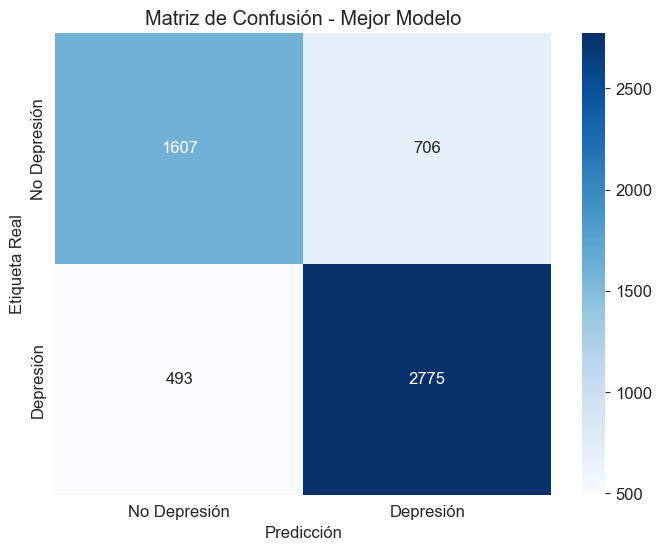


Reporte de Clasificación:
              precision    recall  f1-score   support

No Depresión       0.77      0.69      0.73      2313
   Depresión       0.80      0.85      0.82      3268

    accuracy                           0.79      5581
   macro avg       0.78      0.77      0.78      5581
weighted avg       0.78      0.79      0.78      5581



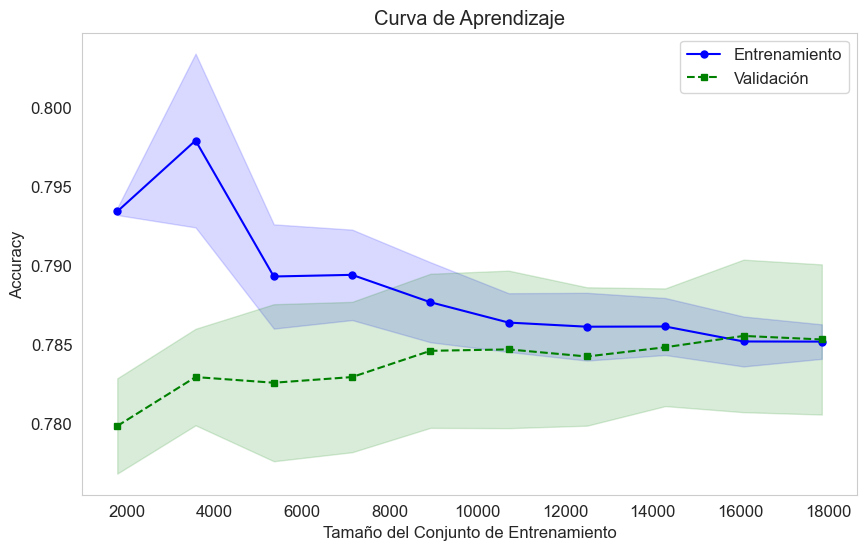

In [8]:
# Paso adicional: Evaluación del mejor modelo

# Obtener configuración del mejor modelo
best_mlp = best_model.named_steps['mlpclassifier']
best_alpha = best_alpha_row['alpha']
print(f"\nEntrenando modelo final con alpha={best_alpha}")

# Crear pipeline con escalador + mejor configuración
mlp_final = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=best_mlp.hidden_layer_sizes,
        solver=best_mlp.solver,
        activation=best_mlp.activation,
        alpha=best_alpha,
        random_state=123,
        max_iter=1000
    )
)

# Entrenar el modelo final
mlp_final.fit(X_train_prep, y_train)

# Evaluar en conjunto de prueba
y_pred = mlp_final.predict(X_test_prep)
final_acc = accuracy_score(y_test, y_pred)

print(f"Accuracy final: {final_acc:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Depresión', 'Depresión'],
            yticklabels=['No Depresión', 'Depresión'])
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Depresión', 'Depresión']))

# Curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    mlp_final, X_train_prep, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validación')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Curva de Aprendizaje')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## Conclusión final usando técnica de redes neuronales

Durante el desarrollo del informe aplicamos las técnica de redes neuronales al problema de predicción de síntomas depresivos en estudiantes universitarios, utilizando un conjunto de datos con información sobre su salud, hábitos y estilo de vida. A lo largo del proceso, realizamos diferentes pruebas con arquitecturas de red, funciones de activación y valores del hiperparámetro alpha.

El mejor rendimiento lo obtuvimos con una red neuronal de dos capas ocultas (100 y 50 neuronas), función de activación tanh, optimizador adam y un valor de alpha = 0.0001. Este modelo alcanzó una precisión del 78.52%, con un f1-score de 0.82 en la clase “Depresión”, lo que indica un buen equilibrio entre precisión y recall en la clase más crítica del problema. También se observó que este modelo logró una mejor capacidad de generalización que otras configuraciones evaluadas.

En general, esta experiencia nos permitió a mi compañero y a mi no solo aplicar los conceptos vistos en clase, sino también comprender la importancia del ajuste de hiperparámetros y la validación cruzada para obtener modelos más robustos. Además, nos ayudó a interpretar métricas clave de evaluación y a reflexionar sobre el impacto que estos modelos pueden tener en el análisis de problemas reales relacionados con la salud mental actuamente.


